## Libraries and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import importlib
from pprint import pprint

from sklearn import linear_model, svm, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor

In [2]:
import clean_and_transform as cat
import feature_engineering as fe

importlib.reload(cat)
importlib.reload(fe)

<module 'feature_engineering' from '/home/jovyan/work/feature_engineering.py'>

In [3]:
# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

## Load

In [4]:
QHC = pd.read_csv("quantity_horizon_cost_data.csv")

## Format

In [5]:
QHC = cat.format_columns_as_date(QHC, ['actual_min_datetime','actual_max_datetime'], "%Y-%m-%d %H:%M:%S")

In [6]:
QHC.describe()

,id,quantity,horizon,total_price,total_cost,total_cost_percentage,L1_variance,L1_TotalBidSize,TotalBidSize
count,15933.000000,1.593300e+04,15933.000000,1.593300e+04,1.593300e+04,15933.000000,15933.000000,1.593300e+04,1.593300e+04
mean,10013.638737,4.551573e+07,33.671248,1.918128e+09,7.611910e+05,0.000334,0.085306,1.411843e+08,3.088705e+09
std,5773.575419,2.851621e+07,15.664349,1.242552e+09,7.620104e+05,0.000194,0.123942,7.286254e+07,1.875359e+09
min,0.000000,1.255300e+04,1.000000,4.620014e+05,7.466226e+00,0.000003,0.003359,2.896555e+07,5.318241e+08
25%,5017.000000,2.051856e+07,21.000000,8.579920e+08,1.848423e+05,0.000188,0.019513,8.779176e+07,1.761031e+09
50%,10038.000000,4.356151e+07,34.000000,1.796748e+09,5.436925e+05,0.000293,0.034410,1.170561e+08,2.432711e+09
75%,15007.000000,6.922095e+07,47.000000,2.884081e+09,1.098296e+06,0.000438,0.087603,1.778804e+08,3.749969e+09
max,19999.000000,9.998296e+07,59.000000,5.367404e+09,7.047160e+06,0.003318,0.695686,3.569487e+08,8.050330e+09


In [7]:
QHC_subset = QHC.head(12000).copy()

## Model

### Create scaled test and train data

In [8]:
X = QHC_subset[['quantity', 'horizon', "L1_variance", "L1_TotalBidSize", "TotalBidSize"]]
y = QHC_subset['total_cost_percentage']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Multiple Linear Regression

In [11]:
mlr_regr = linear_model.LinearRegression()
mlr_regr.fit(X_train_sc, y_train)

LinearRegression()

In [12]:
print(mlr_regr.coef_)

[ 1.05267228e-04 -7.66992245e-05  1.28346047e-05 -1.22404074e-04
  7.45545917e-05]


In [13]:
mlr_y_pred = mlr_regr.predict(X_test_sc)

In [14]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, mlr_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, mlr_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, mlr_y_pred)))

Mean Absolute Error: 0.00010502652117445606
Mean Squared Error: 2.11000053276549e-08
Root Mean Squared Error: 0.0001452584088018828


In [15]:
mlr_score = mlr_regr.score(X_test_sc, y_test)
print(mlr_score)

0.44711607652900764


### Support Vector Regression

In [16]:
sc_y = StandardScaler()

svr_y_train_sc = sc_y.fit_transform(y_train.values.reshape(-1, 1))
svr_y_test_sc = sc_y.transform(y_test.values.reshape(-1, 1))

In [17]:
svr_regr = svm.SVR(kernel='rbf', tol = 1e-6, C=100, gamma=0.1)
svr_regr.fit(X_train_sc, svr_y_train_sc.ravel())

SVR(C=100, gamma=0.1, tol=1e-06)

In [18]:
svr_y_pred = svr_regr.predict(X_test_sc)

In [19]:
print('Mean Absolute Error:', metrics.mean_absolute_error(svr_y_test_sc, svr_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(svr_y_test_sc, svr_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(svr_y_test_sc, svr_y_pred)))

Mean Absolute Error: 0.4175445586707579
Mean Squared Error: 0.386735167747957
Root Mean Squared Error: 0.621880348417569


In [20]:
svr_score = svr_regr.score(X_test_sc, svr_y_test_sc)
print(svr_score)

0.6177656509928947


### Random Forest Regression

In [21]:
rfr_regr = RandomForestRegressor(n_estimators=200, random_state=42)
rfr_regr.fit(X_train_sc, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [22]:
rfr_y_pred = rfr_regr.predict(X_test_sc)

In [23]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rfr_y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, rfr_y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, rfr_y_pred)))

Mean Absolute Error: 8.308488089854158e-05
Mean Squared Error: 1.4647025065608421e-08
Root Mean Squared Error: 0.0001210248944044506


In [24]:
rfr_score = rfr_regr.score(X_test_sc, y_test)
print(rfr_score)

0.6162036663167234


## Misc

<AxesSubplot:>

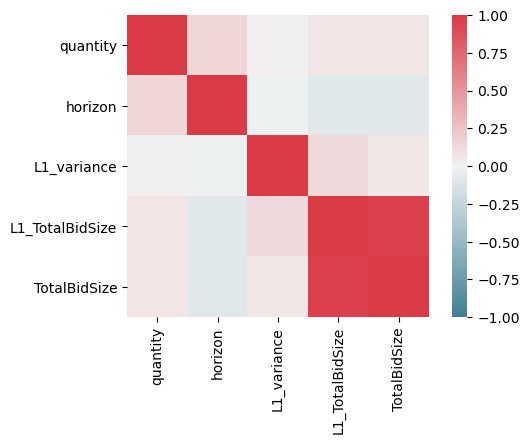

In [25]:
# Check correlation
import seaborn as sns
corr = X.corr()
sns.heatmap(
    corr, 
    mask=np.zeros_like(corr, dtype=bool), 
    cmap=sns.diverging_palette(220, 10, as_cmap=True), 
    vmin=-1, vmax=1,
    square=True)

In [ ]:
C_range = [0.01, 0.1, 1, 10, 100, 1000] #np.logspace(-2, 4, 13)
gamma_range = [0.000001, 0.0001, 0.01, 1] # np.logspace(-8, 1, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

grid = GridSearchCV(svm.SVR(), param_grid=param_grid, verbose = 2.5)

grid.fit(X_sc_train, y_sc_train.ravel())

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))